In [1]:
from sklearn import metrics
import joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from numpy.random import seed
seed(42)
import tensorflow as tf

In [4]:
import pytz
from datetime import timedelta, datetime
local_tz = pytz.timezone('America/Toronto') # Set local timezone for InfluxDB based times calculations
today=datetime.today().strftime('%Y-%m-%d')

#### Note: if you did not create new data for the model training, a sample is provided in this repository. 
#### To use it, ensure that in the next cell the instruction with the file name lt_results_2022-10-01.csv in it is executed and not the one using "today's" date

In [5]:
#data = pd.read_csv('lt_results_'+today+'.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)
data = pd.read_csv('lt_results_2022-10-01.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)

In [6]:
data.head()

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,req2xx,testDurationSeconds,timeoutSeconds
DateTime,,,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,50679.0,165.0,5.0
2022-09-28 15:34:42+00:00,True,30.0,173.0,2788.0,158.0,1.0,347.427221,35.0,146793.0,423.0,5.0
2022-09-28 15:47:10+00:00,True,28.0,125.0,1411.0,110.0,15.0,138.693699,14.0,84757.0,611.0,5.0
2022-09-28 15:56:35+00:00,True,14.0,115.0,1176.0,100.0,12.0,158.212165,16.0,68515.0,433.0,5.0
2022-09-28 16:01:09+00:00,True,30.0,226.0,2296.0,211.0,12.0,245.806605,25.0,34173.0,139.0,5.0


In [7]:
data = data.drop(columns=['req2xx', 'testDurationSeconds'])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data.mean_tps,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((74, 9), (9, 9))

In [9]:
target_var = 'mean_tps'
X_train = X_train.drop(target_var, axis=1)
X_test = X_test.drop(target_var, axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
stdScaler = StandardScaler()
targetStdScaler = StandardScaler()

In [12]:
X_train_scaled = stdScaler.fit_transform(X_train.values)
y_train_scaled = targetStdScaler.fit_transform(y_train.values.reshape(-1,1))

In [13]:
X_test_scaled = stdScaler.transform(X_test.values)
y_test_scaled = targetStdScaler.transform(y_test.values.reshape(-1,1))

In [14]:
# Neural Nets imports
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [15]:
import ray

In [16]:
ray.shutdown()

In [17]:
ray_endpoint = 'ray://raycluster-complete-head-svc.raycluster.svc.cluster.local:10001'

In [18]:
import os

In [19]:
#Retrieve AWS access from the data connection attached to the workbench
aws_access_key_id = os.environ["AWS_ACCESS_KEY_ID"]
aws_secret_access_key = os.environ["AWS_SECRET_ACCESS_KEY"]
endpoint_url = os.environ["AWS_S3_ENDPOINT"]
bucket_name = os.environ["AWS_S3_BUCKET"]
region_name = os.environ["AWS_DEFAULT_REGION"]

In [20]:
ray.init(address=ray_endpoint)

Python version:,3.8.13
Ray version:,2.4.0
Dashboard:,http://10.131.0.84:8265


In [21]:
verboseLevel=0
validationSplit=0.2
batchSize=30
epochs=1000

In [22]:
# callback preparation
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=verboseLevel,
                              mode='min',
                              min_lr=0.001)

In [23]:
inputSize = X_train_scaled.shape[1]
colList = ['HiddenLayers', 'R2Score', 'MAE', 'MSE', 'MAPE', 'H5FileName', 'TrainHistory', 'TrainPredictions']

In [24]:
target_loss = 'mae'
#loss = 'mse'
measure_metrics = ['mae', 'mse']
#measure_metrics = ['mae']

In [25]:
# This function is the reference for creating and training the models inside the Jupyter notebook pod. We will evaluate it against the Ray cluster distributed one
def createModel(testResultsFrame, layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
    print(f'Creating model using layer size = {layerSize} on set = {labelSet}.\n')
    for i in range(loops):
        print(f'Training on {i} hidden layers\n')
        model = Sequential()
        model.add(Dense(layerSize, kernel_initializer='normal',
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        input_dim=inputSize, activation='relu'))
        for j in range(i):
            model.add(Dense(layerSize, 
                            #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                            #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                            kernel_initializer='normal', activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer='normal', 
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        activation='linear'))

        optmzr=Adam(learning_rate=0.001)    
        model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

        model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(i) + '_model_std_' + labelSet + '.h5'
        checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                                 monitor='val_loss',
                                 verbose=verboseLevel,
                                 save_best_only=True,
                                 mode='min')
        callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

        history_MLP_std = model.fit(X_train, y_train,
                                    batch_size=batchSize, 
                                    validation_split=validationSplit, 
                                    epochs=epochs, verbose=verboseLevel,
                                    callbacks=callbacks_list_nn_std)

        #reload the best model!
        model_new = load_model(model_h5_name)
        #Predict
        y_pred_scaled = model_new.predict(X_test)
        #Evaluate metrics
        y_pred = targetScaler.inverse_transform(y_pred_scaled)
        r2_score = metrics.r2_score(y_test, y_pred)
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
        #store values
        row = [i, r2_score, mae, mse, mape, model_h5_name, history_MLP_std, y_pred]
        df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
        testResultsFrame = testResultsFrame.append(df, ignore_index=True)

        tf.keras.backend.clear_session()
        del(model)
        del(model_new)
        
    return testResultsFrame


In [26]:
@ray.remote
def createRemoteModel(layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
    print(f'Creating model using {loops} hidden layers of size = {layerSize} on set = {labelSet}.\n')
    model = Sequential()
    model.add(Dense(layerSize, kernel_initializer='normal',
                    #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                    #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                    input_dim=inputSize, activation='relu'))
    for j in range(loops):
        model.add(Dense(layerSize, 
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal', 
                    #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                    #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                    activation='linear'))

    optmzr=Adam(learning_rate=0.001)    
    model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

    model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(loops) + '_model_std_' + labelSet + '.h5'
    checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                             monitor='val_loss',
                             verbose=verboseLevel,
                             save_best_only=True,
                             mode='min')
    callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

    history_MLP_std = model.fit(X_train, y_train,
                                batch_size=batchSize, 
                                validation_split=validationSplit, 
                                epochs=epochs, verbose=verboseLevel,
                                callbacks=callbacks_list_nn_std)

    #reload the best model!
    model_new = load_model(model_h5_name)
    #Predict
    y_pred_scaled = model_new.predict(X_test)
    #Evaluate metrics
    y_pred = targetScaler.inverse_transform(y_pred_scaled)
    r2_score = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    #store values
    row = [loops, r2_score, mae, mse, mape, model_h5_name, history_MLP_std, y_pred]
    #df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
    #testResultsFrame = testResultsFrame.append(df, ignore_index=True)

    #tf.keras.backend.clear_session()
    #del(model)
    #del(model_new)
        
    #return testResultsFrame
    return row


In [27]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [28]:
%%time
testResDataFrame = pd.DataFrame(columns=colList)
layerSize = 64
loops = 15
testResDataFrame = createModel(testResDataFrame, layerSize, loops, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, 'all')


Creating model using layer size = 64 on set = all.

Training on 0 hidden layers

Training on 1 hidden layers

Training on 2 hidden layers

Training on 3 hidden layers

Training on 4 hidden layers

Training on 5 hidden layers

Training on 6 hidden layers

Training on 7 hidden layers

Training on 8 hidden layers

Training on 9 hidden layers

Training on 10 hidden layers

Training on 11 hidden layers

Training on 12 hidden layers

Training on 13 hidden layers

Training on 14 hidden layers

CPU times: user 10min 45s, sys: 2min 25s, total: 13min 11s
Wall time: 10min 21s


In [29]:
%%time

testResDataFrame2 = []
layerSize = 64
loops = 15


for i in range(loops):
    rowResult = createRemoteModel.remote(layerSize, i, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, 'all_ray')
    testResDataFrame2.append(rowResult)


tResDF2 = ray.get(testResDataFrame2)

INFO:tensorflow:Assets written to: ram://a5bda550-bcaf-46dd-96b8-1aaca37abd3f/assets


(pid=222, ip=10.131.0.86) 2023-08-04 06:25:08.169751: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=222, ip=10.131.0.86) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=222, ip=10.131.0.85) 2023-08-04 06:25:08.096793: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=222, ip=10.131.0.85) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=778) 2023-08-04 06:25:08.400637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruction

(createRemoteModel pid=222, ip=10.131.0.85) Creating model using 4 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.131.0.85) 
(createRemoteModel pid=222, ip=10.131.0.86) Creating model using 2 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.131.0.86) 
(createRemoteModel pid=778) Creating model using 10 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=778) 
(createRemoteModel pid=286, ip=10.131.0.86) Creating model using 12 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=286, ip=10.131.0.86) 
(createRemoteModel pid=844) Creating model using 14 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=844) 


(pid=223, ip=10.129.0.38) 2023-08-04 06:25:11.179191: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=223, ip=10.129.0.38) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=223, ip=10.129.0.37) 2023-08-04 06:25:11.179219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=223, ip=10.129.0.37) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=223, ip=10.128.2.74) 2023-08-04 06:25:11.327122: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

(createRemoteModel pid=223, ip=10.129.0.37) Creating model using 6 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.129.0.37) 
(createRemoteModel pid=223, ip=10.129.0.38) Creating model using 3 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.129.0.38) 


(pid=224, ip=10.130.0.56) 2023-08-04 06:25:13.071523: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=224, ip=10.130.0.56) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=225, ip=10.130.0.58) 2023-08-04 06:25:13.071149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(pid=225, ip=10.130.0.58) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=224, ip=10.130.0.58) 2023-08-04 06:25:13.071134: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

(createRemoteModel pid=223, ip=10.128.2.74) Creating model using 11 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.128.2.74) 
(createRemoteModel pid=224, ip=10.128.2.76) Creating model using 1 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=224, ip=10.128.2.76) 
(createRemoteModel pid=224, ip=10.128.2.75) Creating model using 0 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=224, ip=10.128.2.75) 
(createRemoteModel pid=223, ip=10.130.0.57) Creating model using 9 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.130.0.57) 
(createRemoteModel pid=307, ip=10.130.0.57) Creating model using 13 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=307, ip=10.130.0.57) 
(createRemoteModel pid=224, ip=10.130.0.56) Creating model using 5 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=224, ip=10.130.0.56) 
(createRemoteModel pid=225, ip=10.130.0.58) Creating mod

(createRemoteModel pid=223, ip=10.129.0.38) 2023-08-04 06:25:52.743562: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=224, ip=10.128.2.75) 2023-08-04 06:25:52.792966: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=223, ip=10.129.0.37) 2023-08-04 06:25:54.013186: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=224, ip=10.128.2.76) 2023-08-04 06:25:54.379104: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=222, ip=10.131.0.85) 2023-08-04 06:25:55.029562: W tensorflow/python/util/util.cc:368

CPU times: user 16.5 s, sys: 3.83 s, total: 20.3 s
Wall time: 2min 19s


In [30]:
%%time

tResDF2 = ray.get(testResDataFrame2)

CPU times: user 11.9 s, sys: 2.03 s, total: 13.9 s
Wall time: 49.9 s


As you can see the ray.get() is a blocking function so it waits until all the tasks for the current job on the ray cluster have completed (in our case the 15 models training).
This method then retrieves the results from the tasks and provides the final result. 
As you can see this takes about 50 seconds, and as the same instruction is present in the ray job cell which completed in 2 min 13s, we can deduct this time and see that the actual training time on the Ray cluster was 1min 23s (vs 10min 24s the training within the notebook image). These values apply to the type of physical resources available in this cluster (your cluster results may differ).

In [31]:
df = pd.DataFrame(tResDF2, columns=colList)

In [32]:
df

,HiddenLayers,R2Score,MAE,MSE,MAPE,H5FileName,TrainHistory,TrainPredictions
0,0,0.996515,4.966991,29.048945,0.023903,mlp_64_0_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe2daa15...,"[[243.55884], [105.24606], [278.90875], [131.6..."
1,1,0.993965,5.855881,50.304637,0.028498,mlp_64_1_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe23ba9d...,"[[252.63795], [100.17087], [288.81482], [138.3..."
2,2,0.998342,3.103025,13.816360,0.014899,mlp_64_2_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe2389b0...,"[[243.90535], [103.150635], [271.70428], [140...."
3,3,0.997865,3.348683,17.798799,0.019976,mlp_64_3_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe238595...,"[[240.33984], [100.75966], [275.08728], [144.7..."
4,4,0.994921,5.237687,42.335525,0.028356,mlp_64_4_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe23836f...,"[[250.76656], [96.218765], [282.81223], [139.0..."
5,5,0.990685,7.169225,77.642690,0.026746,mlp_64_5_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe238082...,"[[253.07698], [108.66411], [286.52985], [141.4..."
6,6,0.996574,4.048770,28.557215,0.019072,mlp_64_6_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe21fd8f...,"[[244.05765], [104.25451], [282.08176], [139.3..."
7,7,0.991756,6.531748,68.716428,0.041941,mlp_64_7_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe21fa93...,"[[240.3879], [91.309845], [279.78415], [127.85..."
8,8,0.993736,5.114268,52.216329,0.019522,mlp_64_8_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe21f7b7...,"[[247.06674], [104.94549], [279.9435], [136.34..."
9,9,0.994247,6.165572,47.954822,0.029198,mlp_64_9_model_std_all_ray.h5,<keras.callbacks.History object at 0x7fe21f41e...,"[[254.93166], [104.1271], [288.5054], [133.489..."


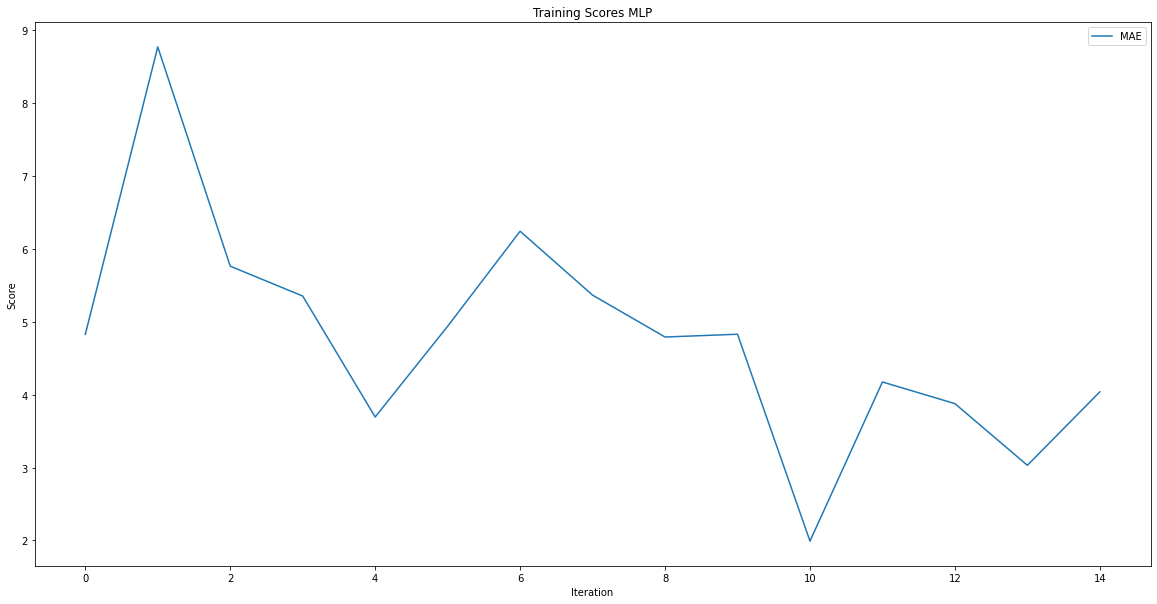

In [33]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(testResDataFrame['R2Score'])
plt.plot(testResDataFrame['MAE'])
#plt.plot(testResDataFrame['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

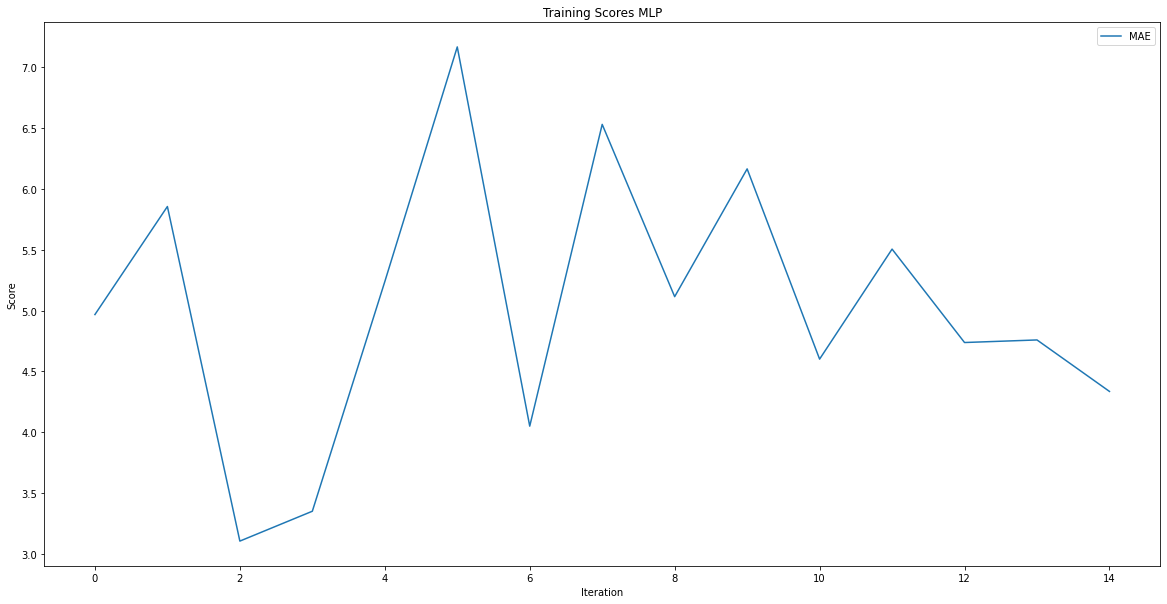

In [34]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(df['R2Score'])
plt.plot(df['MAE'])
#plt.plot(df['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [35]:
# Determine the IDX value where the MAE is smallest
minMaeIDX = testResDataFrame.loc[testResDataFrame['MAE']==testResDataFrame['MAE'].min()].index[0]

In [36]:
testResDataFrame.iloc[minMaeIDX]

HiddenLayers                                                       10
R2Score                                                      0.999297
MAE                                                          1.991544
MSE                                                          5.861188
MAPE                                                         0.009898
H5FileName                                 mlp_64_10_model_std_all.h5
TrainHistory        <keras.callbacks.History object at 0x7fe25842b...
TrainPredictions    [[244.72168], [104.9576], [275.94086], [138.05...
Name: 10, dtype: object

In [37]:
minMaeIDX_ray = df.loc[df['MAE']==df['MAE'].min()].index[0]

In [38]:
df.iloc[minMaeIDX_ray]

HiddenLayers                                                        2
R2Score                                                      0.998342
MAE                                                          3.103025
MSE                                                          13.81636
MAPE                                                         0.014899
H5FileName                              mlp_64_2_model_std_all_ray.h5
TrainHistory        <keras.callbacks.History object at 0x7fe2389b0...
TrainPredictions    [[243.90535], [103.150635], [271.70428], [140....
Name: 2, dtype: object

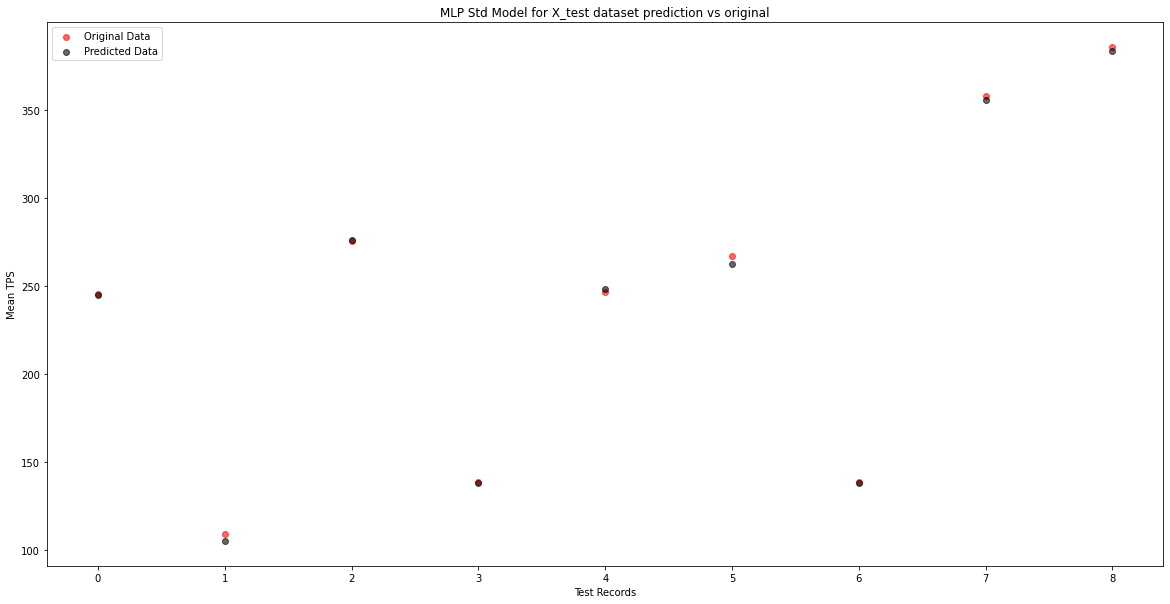

In [39]:
y_pred_MLP_std = testResDataFrame['TrainPredictions'][minMaeIDX]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original')
plt.legend()
plt.show()

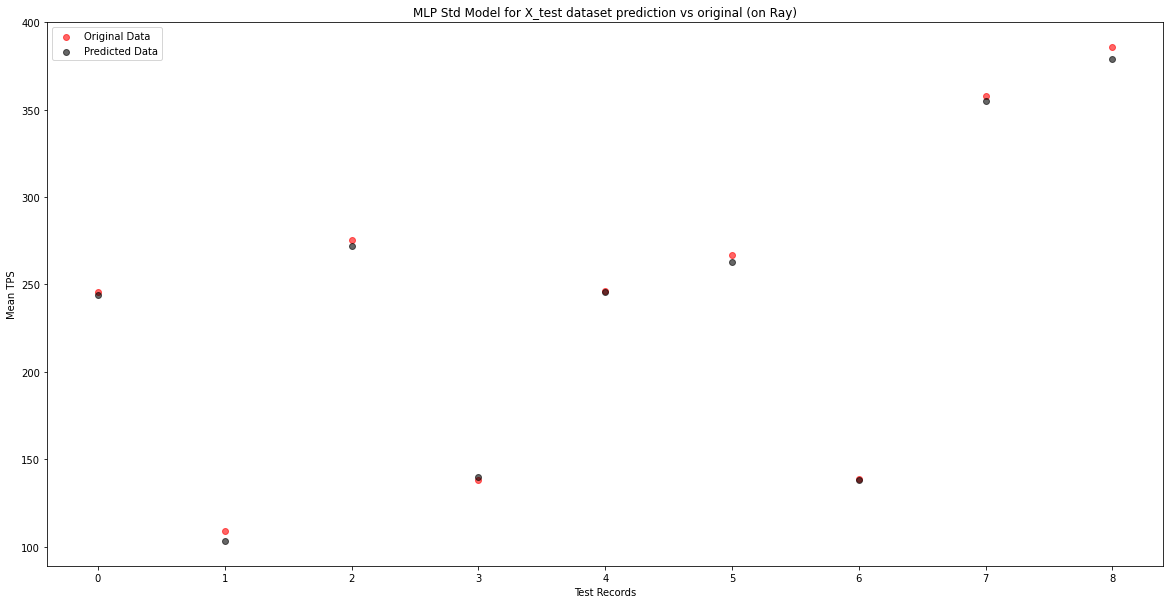

In [40]:
y_pred_MLP_std = df['TrainPredictions'][minMaeIDX_ray]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original (on Ray)')
plt.legend()
plt.show()

In [41]:
X_test.columns

Index(['asyncResp', 'asyncRespThreads', 'cThreads', 'jacptQSize',
       'jacptThreads', 'ltTargetSize', 'numConnections', 'timeoutSeconds'],
      dtype='object')

In [42]:
data.head(1)

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,timeoutSeconds
DateTime,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,5.0


In [43]:
record = [[True, 21, 277, 1712, 262, 7, 31, 5]]

In [44]:
test_rec = stdScaler.transform(record)

In [45]:
test_rec

array([[ 0.34815531, -0.16614866,  1.14391569, -0.53671704,  1.14391569,
        -0.29012346,  0.90504761,  0.30039875]])

In [46]:
test_model = load_model(testResDataFrame['H5FileName'][minMaeIDX])

In [47]:
test_pred = test_model.predict(test_rec)

In [48]:
test_pred

array([[0.8993267]], dtype=float32)

In [49]:
targetStdScaler.inverse_transform(test_pred)

array([[306.28903]], dtype=float32)

### Save the scalers for the inference calls

In [50]:
joblib.dump(targetStdScaler,'target_scaler.pkl')

['target_scaler.pkl']

In [51]:
joblib.dump(stdScaler,'standard_scaler.pkl')

['standard_scaler.pkl']

### Export to ONNX to run on the RHODS model server

In [52]:
!pip install protobuf=="4.23.4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 35.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.7.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.23.4 which is incompatible.
tensorboard 2.6.0 requires google-auth<2,>=1.6.3, but you have google-auth 2.22.0 which is incompatible.
kfp 1.8.22 requires protobuf<4,>=3.13.0, but you have protobuf 4.23.4 which is incompatible.
kfp-pipeline-spec 0.1.16 requires protobuf<4,>=3.13.0, but you have protobuf 4.23.4 which is incompatible.

[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [53]:
import tf2onnx

In [54]:
model_onnx, _ = tf2onnx.convert.from_keras(test_model, output_path='tf_mlasp.onnx')

In [55]:
!pip install protobuf=="3.19.6"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.6.0 requires google-auth<2,>=1.6.3, but you have google-auth 2.22.0 which is incompatible.
onnx 1.14.0 requires protobuf>=3.20.2, but you have protobuf 3.19.6 which is incompatible.

[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


### Upload model to S3 bucket

In [56]:
import boto3
import botocore

In [57]:
#S3 ODF GW client
s3_odf = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = 'default',
                      endpoint_url = endpoint_url,
                      config = botocore.client.Config(signature_version = 's3'))

In [58]:
s3_odf.upload_file('tf_mlasp.onnx', bucket_name, 'models/tf_mlasp.onnx')

In [59]:
ray.shutdown()

In [60]:
s3_odf.upload_file('lt_results_2022-10-01.csv', bucket_name, 'data/lt_results_2022-10-01.csv')